In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install impyute

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from impyute.imputation.cs import mice

from functools import reduce
from sklearn.base import TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, MultiLabelBinarizer, PowerTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer

In [ ]:
TRAIN_CSV_FILE = "/content/drive/MyDrive/apeAndDogs/data/train.csv"
TEST_CSV_FILE = "/content/drive/MyDrive/apeAndDogs/data/test.csv"

In [ ]:
df = pd.read_csv(TRAIN_CSV_FILE)

In [ ]:
df[:100]

,Id,Week,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,target
0,-6536978109522202983,0,0.000000,0.0,0.000000,0.011364,0.006579,0.03110,0.013158,0.006579,0.228694,0.000000,0.333073,0.0,0.000000,0.019737,0.064203,0.263279,0.011364,0.000000,0.000000,0.000000,0.010870,0.000000,86.0,24137.0,0.666667,5.205102,77.950000,21.400000,132.666667,0.000000,0.000000,0.166667,0.000000,4.82,0.000000,2440.153846,301.566667,0.500000,12.076923,11038.166667,15.400000,4.82,8.911111,200.0,0.000000,4.820000,0.333333,6712.0,0.333333,0.0
1,-6536978109522202983,1,0.000000,0.0,0.000000,0.011364,0.006579,0.03110,0.013158,0.006579,0.228694,0.000000,0.333073,0.0,0.000000,0.019737,0.064203,0.263279,0.011364,0.000000,0.000000,0.000000,0.010870,0.000000,64.0,43316.0,0.347826,3.926019,105.650000,10.800000,154.608696,0.000000,0.000000,0.130435,0.130435,4.82,0.130435,1761.000000,487.050000,0.217391,10.518868,14078.000000,17.016667,4.82,8.292754,510.0,0.000000,4.820000,0.652174,4873.0,0.391304,0.0
2,-6536978109522202983,2,0.000000,0.0,0.000000,0.011364,0.006579,0.03110,0.013158,0.006579,0.228694,0.000000,0.333073,0.0,0.000000,0.019737,0.064203,0.263279,0.011364,0.000000,0.000000,0.000000,0.010870,0.000000,59.0,19961.0,0.500000,3.627770,38.100000,11.766667,122.318182,0.000000,0.000000,0.181818,0.227273,4.82,0.181818,1560.333333,92.733333,0.227273,7.974747,10814.454545,41.100000,4.82,9.753030,190.0,0.000000,4.820000,0.500000,2175.0,0.181818,0.0
3,-6536978109522202983,3,0.000000,0.0,0.000000,0.011364,0.006579,0.03110,0.013158,0.006579,0.228694,0.000000,0.333073,0.0,0.000000,0.019737,0.064203,0.263279,0.011364,0.000000,0.000000,0.000000,0.010870,0.000000,67.0,40729.0,0.473684,3.348995,86.983333,15.366667,152.368421,0.026316,0.026316,0.105263,0.105263,4.78,0.131579,2028.533333,487.016667,0.263158,17.708333,13842.052632,33.850000,4.82,10.520614,382.0,0.026316,4.814737,0.447368,4093.0,0.394737,0.0
4,-1744017237843019509,0,0.051282,1.0,0.014363,0.018308,0.037632,0.00000,0.180246,0.103449,0.379082,0.000000,0.020292,0.0,0.000000,0.000000,0.000000,0.055489,0.071362,0.071817,0.000000,0.047960,0.000000,0.000000,47.0,56986.0,0.304348,3.916232,30.466667,5.200000,143.217391,0.000000,0.000000,0.152174,0.152174,4.86,0.347826,1960.274510,105.433333,0.108696,10.819113,10859.086957,31.866667,4.94,9.438406,777.0,0.021739,4.908478,0.673913,1296.0,0.239130,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-6922372886904422874,3,0.029412,1.0,0.021520,0.008929,0.042353,0.02381,0.190247,0.154533,0.118636,0.008333,0.040064,0.0,0.000000,0.018544,0.038095,0.161172,0.016667,0.018544,0.000000,0.117033,0.009615,0.011905,88.0,54133.0,0.190476,2.484374,46.066667,17.550000,289.761905,0.047619,0.000000,0.095238,0.190476,4.94,0.000000,1841.823529,103.366667,0.095238,7.744485,22684.380952,27.200000,4.94,9.446825,1063.0,0.095238,4.940000,0.666667,4563.0,0.619048,0.0
96,9009236738956328986,0,0.000000,0.0,0.044107,0.054299,0.013105,0.00000,0.140777,0.140439,0.057427,0.003247,0.039891,0.0,0.121996,0.028420,0.055606,0.043673,0.022778,0.038240,0.003247,0.103586,0.073469,0.015693,132.0,35218.0,0.166667,3.269802,50.500000,23.783333,210.309524,0.000000,0.000000,0.000000,0.142857,4.94,0.000000,1319.365385,106.750000,0.000000,6.731707,20584.047619,23.150000,4.98,7.623413,327.0,0.023810,4.970476,0.809524,11812.0,0.857143,0.0
97,9009236738956328986,1,0.000000,0.0,0.044107,0.054299,0.013105,0.00000,0.140777,0.140439,0.057427,0.003247,0.039891,0.0,0.121996,0.028420,0.055606,0.043673,0.022778,0.038240,0.003247,0.103586,0.073469,0.015693,56.0,60571.0,0.138889,3.127868,52.583333,14.666667,212.791667,0.027778,0.013889,0.013889,0.097222,4.92,0.027778,1204.842105,105.316667,0.013889,8.941176,21023.305556,22.133333,4.98,7.205093

In [ ]:
df[df['P1'].isnull()]

,Id,Week,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,target,Nans_count
37,2613624642939049264,2,0.025641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,47
40,-4594438104292881304,1,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,47
42,-4594438104292881304,3,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,47
43,-4594438104292881304,4,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,47
60,-5047395994999992020,1,0.212121,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30822,-4350051525831378104,3,0.043478,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,47
30823,-4350051525831378104,4,0.043478,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,47
30824,-3918751256168709671,1,0.533333,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,47
30846,-3951248822562299280,3,0.025641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,47


In [ ]:
df['Nans_count'] = df.isnull().sum(axis=1)

In [ ]:
churned_drivers = (df[df['target'] == 1])
unchurned_drivers = (df[df['target'] == 0])

In [ ]:
churned_drivers.Nans_count.value_counts()

0     2072
20    1699
47    1484
49      36
46      35
48      12
37       3
29       3
Name: Nans_count, dtype: int64

In [ ]:
unchurned_drivers.Nans_count.value_counts()

0     21688
20     2484
47     1329
46       14
37        1
Name: Nans_count, dtype: int64

In [ ]:
df["Week"] = df["Week"] + 1

In [ ]:
df.groupby(["Id"])['Week'].sum().reset_index()['Week'].min()

10

In [ ]:
class DFColumnDropper(TransformerMixin):
    # Drop specified columns

    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Xcols = X.drop(self.cols_to_drop, axis=1)
        return Xcols

class DFSimpleImputer(TransformerMixin):
    # Replace np.nan values with given strategy

    def __init__(self, strategy='mean'):
        self.strategy = strategy
        self.imp = None
        self.statistics_ = None

    def fit(self, X, y=None):
        self.imp = SimpleImputer(strategy=self.strategy)
        self.imp.fit(X)
        self.statistics_ = pd.Series(self.imp.statistics_, index=X.columns)
        return self

    def transform(self, X):
        Ximp = self.imp.transform(X)
        Xfilled = pd.DataFrame(Ximp, index=X.index, columns=X.columns)
        return Xfilled

class DFIntelectualImputer(TransformerMixin):
    # Replace np.nan values with given strategy

    # def __init__(self):
    #     self.strategy = strategy
    #     self.imp = None
    #     self.statistics_ = None

    def fit(self, X, y=None):
        # self.imp = SimpleImputer(strategy=self.strategy)
        # self.imp.fit(X)
        # self.statistics_ = pd.Series(self.imp.statistics_, index=X.columns)
        return self

    def transform(self, X):
        return mice(X)

class DFStandardScaler(TransformerMixin):
    # Do same thing that StandardScaller does

    def __init__(self):
        self.ss = None
        self.mean_ = None
        self.scale_ = None

    def fit(self, X, y=None):
        self.ss = StandardScaler()
        self.ss.fit(X)
        self.mean_ = pd.Series(self.ss.mean_, index=X.columns)
        self.scale_ = pd.Series(self.ss.scale_, index=X.columns)
        return self

    def transform(self, X):
        Xss = self.ss.transform(X)
        Xscaled = pd.DataFrame(Xss, index=X.index, columns=X.columns)
        return Xscaled


class DummyTransformer(TransformerMixin):
    # Do one hot encoding on text columns

    def __init__(self):
        self.dv = None

    def fit(self, X, y=None):
        # assumes all columns of X are strings
        Xdict = X.to_dict('records')
        self.dv = DictVectorizer(sparse=False)
        self.dv.fit(Xdict)
        return self

    def transform(self, X):
        Xdict = X.to_dict('records')
        Xt = self.dv.transform(Xdict)
        cols = self.dv.get_feature_names()
        Xdum = pd.DataFrame(Xt, index=X.index, columns=cols)
        # drop column indicating NaNs
        nan_cols = [c for c in cols if '=' not in c]
        Xdum = Xdum.drop(nan_cols, axis=1)
        return Xdum

class DFPowerTransformer(TransformerMixin):
    # transform power to normal dist
    def __init__(self, method='box-cox'):
        self.method = method
        self.pt = PowerTransformer(method=method, standardize=True)
        self.mm = MinMaxScaler(feature_range=(1, 100))

    def fit(self, X, y=None):
        if self.method == 'box-cox':
            X = self.mm.fit_transform(X, y)
        self.pt.fit(X, y)
        return self

    def transform(self, X):
        if self.method == 'box-cox':
            X = self.mm.transform(X)
        return self.pt.transform(X)

class DFFeatureUnion(TransformerMixin):
    # Merge DFs

    def __init__(self, transformer_list):
        self.transformer_list = transformer_list

    def fit(self, X, y=None):
        for (name, t) in self.transformer_list:
            t.fit(X, y)
        return self

    def transform(self, X):
        Xts = [t.transform(X) for _, t in self.transformer_list]
        Xunion = reduce(lambda X1, X2: pd.merge(X1, X2, left_index=True, right_index=True), Xts)
        return Xunion

class ColumnExtractor(TransformerMixin):
    # Selects sprecified columns

    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Xcols = X[self.cols]
        return Xcols

In [ ]:
df.nunique()

Id             7715
Week              4
V1              262
V2               29
V3             3475
V4             3617
V5             1196
V6              635
V7             5068
V8             5071
V9             4272
V10            1222
V11            4209
V12             853
V13             773
V14            2228
V15            3908
V16            3029
V17            2935
V18            3977
V19             936
V20            5169
V21            3204
V22             968
P1              261
P2            20255
P3             2787
P4            27945
P5             4371
P6             2086
P7            22022
P8             1240
P9              975
P10            1347
P11            1616
P12              71
P13            2333
P14           26743
P15            8694
P16            1951
P17           22948
P18           27778
P19            4041
P20              63
P21           25930
P22             928
P23             390
P24            9939
P25            2827
P26            8184


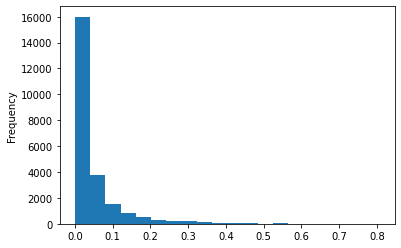

In [ ]:
df['V3'].plot.hist(bins=20)

In [ ]:
CAT_COLS = []
COLS_TO_DROP = []
IGNORED_COLS = ['Id', 'Week']

In [ ]:
pt = PowerTransformer(method='box-cox', standardize=True)
mm = MinMaxScaler(feature_range=(1, 100))
transformed_power = pd.DataFrame(data=pt.fit_transform(mm.fit_transform(df)), columns=df.columns)

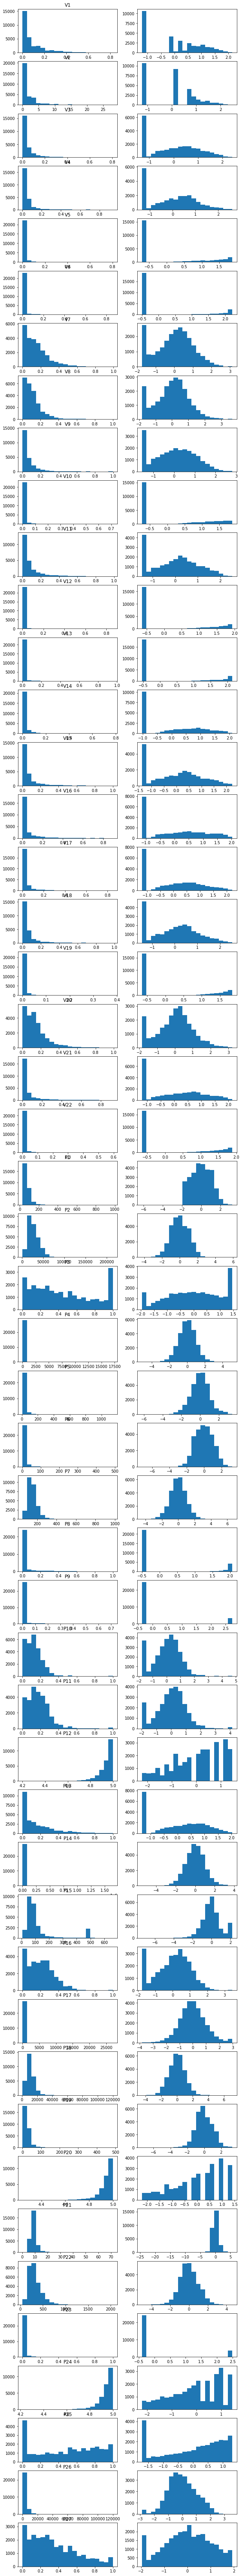

In [ ]:
fig, axs = plt.subplots(len(FLOAT_COLS), 2)
fig.set_figheight(120)
fig.set_figwidth(10)
for i in range(len(FLOAT_COLS)):
  axs[i][0].hist(df[FLOAT_COLS[i]], bins=20)
  axs[i][1].hist(transformed_power[FLOAT_COLS[i]], bins=20)
  axs[i][0].set_title(FLOAT_COLS[i])

In [ ]:
pt2 = PowerTransformer(standardize=True)
transformed_power_yeojohnson = pd.DataFrame(data=pt2.fit_transform(df), columns=df.columns)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [ ]:
transformed_power.describe()

,Id,Week,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,target,Nans_count
count,3.086000e+04,3.086000e+04,3.081200e+04,3.081200e+04,2.376000e+04,2.376000e+04,2.376000e+04,2.376000e+04,2.376000e+04,2.376000e+04,2.376000e+04,2.376000e+04,2.376000e+04,2.376000e+04,2.376000e+04,2.376000e+04,2.376000e+04,2.376000e+04,2.376000e+04,2.376000e+04,2.376000e+04,2.376000e+04,2.376000e+04,2.376000e+04,2.794600e+04,2.794600e+04,2.794700e+04,2.794700e+04,2.794600e+04,2.794600e+04,2.794600e+04,2.794700e+04,2.794700e+04,2.794600e+04,2.794600e+04,2.794600e+04,2.794600e+04,2.801100e+04,2.794600e+04,2.794600e+04,2.794700e+04,2.794600e+04,2.794700e+04,2.794600e+04,2.794700e+04,2.794600e+04,2.794700e+04,2.794600e+04,2.794700e+04,2.794600e+04,2.794600e+04,3.086000e+04,3.086000e+04
mean,-3.227058e-16,-3.330669e-16,2.654037e-16,-7.449217e-16,1.390573e-15,1.782899e-16,7.584001e-16,-8.271722e-16,2.077369e-16,-1.297690e-16,-1.581974e-16,2.403437e-15,1.420674e-16,-1.466999e-15,-1.245291e-15,-6.301427e-16,1.018176e-15,6.944688e-16,8.626096e-16,-4.207727e-16,1.033872e-16,5.252065e-18,-4.586352e-16,-3.651737e-15,-5.359271e-16,1.443536e-16,4.307452e-16,2.836755e-16,-2.654270e-16,1.485488e-15,7.071762e-16,3.475415e-15,1.163627e-15,-1.277317e-16,-4.483242e-16,1.452642e-15,-3.412905e-16,-4.621312e-16,2.578817e-16,-3.631287e-16,3.886953e-16,6.365845e-16,6.046677e-16,-1.466769e-15,1.914476e-15,-6.203678e-16,3.580681e-15,5.122933e-16,-8.095765e-17,3.964242e-16,6.606673e-18,1.740179e-15,-6.297490e-15
std,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000016e+00,1.000016e+00
min,-2.081167e+00,-1.550149e+00,-1.214669e+00,-1.229582e+00,-1.304097e+00,-1.354000e+00,-7.047237e-01,-5.004750e-01,-1.758986e+00,-1.833238e+00,-1.562877e+00,-7.343846e-01,-1.482224e+00,-6.350275e-01,-5.382927e-01,-1.029798e+00,-1.380197e+00,-1.148976e+00,-1.193582e+00,-1.454805e+00,-6.492453e-01,-1.859232e+00,-1.196039e+00,-6.511874e-01,-6.197415e+00,-4.267587e+00,-1.962685e+00,-5.147435e+00,-6.231595e+00,-7.188876e+00,-4.455813e+00,-5.098294e-01,-3.693192e-01,-1.787025e+00,-1.982655e+00,-2.229057e+00,-1.328139e+00,-5.472404e+00,-7.383484e+00,-1.783225e+00,-3.840294e+00,-4.496752e+00,-7.389202e+00,-2.205727e+00,-2.446359e+01,-5.045110e+00,-4.052391e-01,-2.217509e+00,-1.721148e+00,-2.879169e+00,-1.965960e+00,-4.576431e-01,-5.466274e-01
25%,-7.831200e-01,-4.915912e-01,-1.214669e+00,-1.229582e+00,-1.304097e+00,-1.004533e+00,-7.047237e-01,-5.004750e-01,-6.569489e-01,-6.295894e-01,-7.652101e-01,-7.343846e-01,-8.093773e-01,-6.350275e-01,-5.382927e-01,-1.029798e+00,-9.157536e-01,-1.148976e+00,-1.193582e+00,-8.147714e-01,-6.492453e-01,-6.221459e-01,-1.196039e+00,-6.511874e-01,-8.011571e-01,-7.084369e-01,-7.476020e-01,-6.288232e-01,-6.067003e-01,-7.476927e-01,-6.389830e-01,-5.098294e-01,-3.693192e-01,-5.709973e-01,-5.671223e-01,-7.674032e-01,-1.328139e+00,-6.367821e-01,-5.704713e-01,-6.674622e-01,-6.301900e-01,-6.609076e-01,-6.494529e-01,-8.308494e-01,-6.071215e-01,-6.577935e-01,-4.052391e-01,-7.224482e-01,-7.739889e-01,-6.886513e-01,-6.799511e-01,-4.576431e-01,-5.466274e-01
50%,8.742137e-02,2.151846e-01,2.145791e-01,1.507501e-01,8.593647e-02,1.051547e-01,-7.047237e-01,-5.004750e-01,9.309549e-02,7.941847e-02,5.151838e-02,-7.343846e-01,7.619726e-02,-6.350275e-01,-5.38292

In [ ]:
pd.DataFrame(mice(transformed_power[["V" + str(i) for i in range(1, 5)]].values), columns=transformed_power.columns[:4]).describe()

,Id,Week,V1,V2
count,3.086000e+04,3.086000e+04,30860.000000,30860.000000
mean,2.649909e-16,-7.437631e-16,0.002193,0.004624
std,9.992382e-01,9.992382e-01,0.877537,0.877778
min,-1.214669e+00,-1.229582e+00,-1.304097,-1.354000
25%,-1.214669e+00,-1.229582e+00,-0.581205,-0.516795
50%,2.145791e-01,1.507501e-01,0.010490,0.024560
75%,8.653256e-01,6.327983e-01,0.567922,0.573176
max,2.148418e+00,2.486535e+00,2.409362,2.620067


In [ ]:
BOXCOX_COLS = ['V' + str(i) for i in (list(range(1, 5)) + [9, 11] + list(range(14, 19)) + [21])]
BOXCOX_COLS += ['P' + str(i) for i in (list(range(1, 8)) + list(range(13, 23)) + list(range(24, 28)))]
YEOJHONSON_COLS = ['V' + str(i) for i in (list(range(5, 9)) + [10, 12, 13, 19, 20, 22])]
YEOJHONSON_COLS += ['P' + str(i) for i in (list(range(8, 13)) + [23])]

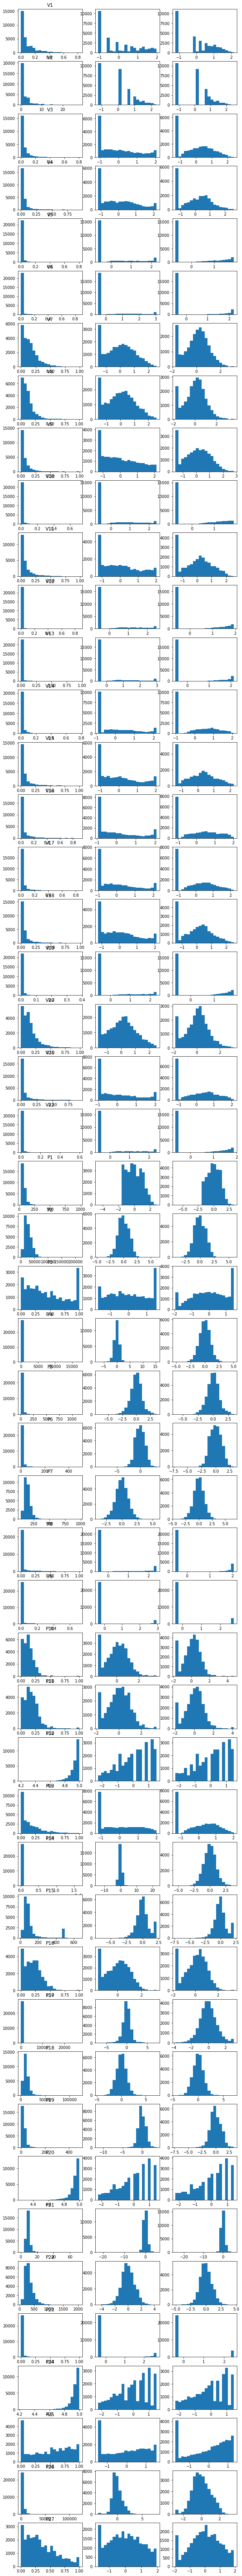

In [ ]:
fig, axs = plt.subplots(len(FLOAT_COLS), 3)
fig.set_figheight(120)
fig.set_figwidth(10)
for i in range(len(FLOAT_COLS)):
  axs[i][0].hist(df[FLOAT_COLS[i]], bins=20)
  axs[i][1].hist(transformed_power_yeojohnson[FLOAT_COLS[i]], bins=20)
  axs[i][2].hist(transformed_power[FLOAT_COLS[i]], bins=20)
  axs[i][1].set_title(FLOAT_COLS[i])

In [ ]:
pipeline = Pipeline([
    ('drop', DFColumnDropper(COLS_TO_DROP)),
    ('features', DFFeatureUnion([
        ('skip', ColumnExtractor(IGNORED_COLS)),
        ('boxcox', Pipeline([
            ('extract', ColumnExtractor(BOXCOX_COLS)),
            ('scale', DFPowerTransformer()),
            ('nan_filler', DFIntelectualImputer())
        ])),
        ('jhonson', Pipeline([
            ('extract', ColumnExtractor(YEOJHONSON_COLS)),
            ('scale', DFPowerTransformer(method='yeo-johnson')),
            ('nan_filler', DFIntelectualImputer())
        ]))
    ]))
])

In [ ]:
pipeline.fit(df)
prepared_df = pipeline.transform(df)

In [ ]:
prepared_df.to_csv('train_prepared.csv')

NameError: ignored

In [ ]:
df_test = pd.read_csv(TEST_CSV_FILE)

In [ ]:
prepared_test_df = pipeline.transform(df_test)
prepared_test_df.to_csv('test_prepared.csv')